In [1]:
import numpy as np
import h5py
import keras
from collections import OrderedDict

Using TensorFlow backend.


In [2]:
!echo $CUDA_VISIBLE_DEVICES

4


In [133]:
celltype_to_corefiles = {
    'HepG2': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/HepG2.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/no_HepG2_universal_dnase.matched.valid.bed.gz'
    },
    'A549': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.matched.valid.bed.gz'
    },
    'H1ESC': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/H1ESC.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/no_H1ESC_universal_dnase.matched.valid.bed.gz'
    },
    'K562': {
        'modeljson': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelJson.json',
        'modelweights': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.pos.summits.valid.implanted.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.neg.summits.valid.implanted.bed.gz'
    }
}

In [134]:
import keras
import gzip
import tensorflow as tf
import deeplift.dinuc_shuffle


def load_keras_model(modeljson, modelweights):
    model = keras.models.model_from_json(open(modeljson).read())
    model.load_weights(modelweights)
    return model

    
def onehot_encode(seqs):
    ltr = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], 'N': [0,0,0,0]}
    return np.array([[ltr[x] for x in seq.upper()] for seq in seqs])


def load_seqs_and_onehot(sequences_file):
    seqids = []
    seqs = []
    for line in gzip.open(sequences_file):
        seqid, seq = line.decode("utf-8").rstrip().split("\t")
        seqids.append(seqid)
        seqs.append(seq)
    onehotseqs = onehot_encode(seqs)
    return seqids, seqs, onehotseqs


def empty_ism_buffer(results_arr,
                     input_data_onehot,
                     perturbed_inputs_preds,
                     perturbed_inputs_info):
    for perturbed_input_pred,perturbed_input_info\
        in zip(perturbed_inputs_preds, perturbed_inputs_info):
        example_idx = perturbed_input_info[0]
        if (perturbed_input_info[1]=="original"):
            results_arr[example_idx] +=\
                (perturbed_input_pred*input_data_onehot[example_idx])
        else:
            pos_idx,base_idx = perturbed_input_info[1]
            results_arr[example_idx,pos_idx,base_idx] = perturbed_input_pred

            
def make_ism_func(pred_func,
                  flank_around_middle_to_perturb,
                  batch_size=200):
    def ism_func(input_onehot, progress_update=1000, **kwargs):
        input_data_onehot=input_onehot
        
        results_arr = np.zeros_like(input_data_onehot).astype("float64")
        
        perturbed_inputs_info = []
        perturbed_onehot_seqs = []
        perturbed_inputs_preds = []
        num_done = 0
        for i,onehot_seq in enumerate(input_data_onehot):
            perturbed_onehot_seqs.append(onehot_seq)
            perturbed_inputs_info.append((i,"original"))
            for pos in range(int(len(onehot_seq)/2)-flank_around_middle_to_perturb,
                             int(len(onehot_seq)/2)+flank_around_middle_to_perturb):
                for base_idx in range(4):
                    if onehot_seq[pos,base_idx]==0:
                        assert len(onehot_seq.shape)==2
                        new_onehot = np.zeros_like(onehot_seq) + onehot_seq
                        new_onehot[pos,:] = 0
                        new_onehot[pos,base_idx] = 1
                        perturbed_onehot_seqs.append(new_onehot)
                        perturbed_inputs_info.append((i,(pos,base_idx)))
                        num_done += 1
                        if ((progress_update is not None)
                            and num_done%progress_update==0):
                            print("Done",num_done)
                        if (len(perturbed_inputs_info)>=batch_size):
                            empty_ism_buffer(
                                 results_arr=results_arr,
                                 input_data_onehot=input_data_onehot,
                                 perturbed_inputs_preds=
                                  pred_func([perturbed_onehot_seqs]),
                                 perturbed_inputs_info=perturbed_inputs_info)
                            perturbed_inputs_info = []
                            perturbed_onehot_seqs = []
        if (len(perturbed_inputs_info)>0):
            empty_ism_buffer(
                 results_arr=results_arr,
                 input_data_onehot=input_data_onehot,
                 perturbed_inputs_preds=
                  pred_func([perturbed_onehot_seqs]),
                 perturbed_inputs_info=perturbed_inputs_info)
        perturbed_inputs_info = []
        perturbed_onehot_seqs = []
        results_arr = results_arr - np.mean(results_arr,axis=-1)[:,:,None]
        return input_data_onehot*results_arr
    return ism_func


def get_project_onto_bases_func(func):
    def project_onto_bases(input_data_list, **kwargs):
        assert len(input_data_list)==1
        to_return = func(input_data_list=input_data_list, **kwargs)
        return input_data_list[0]*np.sum(to_return,axis=-1)[:,:,None]
    return project_onto_bases


def get_grad_func(deeplift_model):
    grad = tf.gradients(
        ys=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars(),
        xs=deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars())[0]
    unbatched_grad_func = deeplift.util.compile_func(
        inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
        outputs=grad)
    #the grad_func needs to be in a deeplift-compatible API
    def grad_func(input_data_list, input_references_list=None, task_idx=None, **kwargs):
        assert len(input_data_list)==1
        to_return = np.array(deeplift.util.run_function_in_batches(
                        unbatched_grad_func,
                        input_data_list=input_data_list,
                        **kwargs))
        return to_return
    return grad_func


def get_grad_times_inp_func(grad_func):
    def grad_times_inp_func(input_onehot, **kwargs):
        grads = grad_func(input_data_list=[input_onehot], **kwargs)
        return grads*input_onehot
    return grad_times_inp_func

#take a scoring func in the deeplift api and distill it
# to essentials, when there is a fixed reference
def distill_deepliftapi_withfixedref(deepliftapifunc, fixedref):
    def distilled_func(input_onehot, **kwargs):
        scores = deepliftapifunc(input_data_list=[input_onehot],
                                 input_references_list=[fixedref],
                                 task_idx=0, **kwargs)
        return scores
    return distilled_func


#take a shuffref scoring function in the deeplift api and distill
# it to essentials
def distill_deepliftapi_multiref(deepliftapifunc, numrefs):
    def distilled_func(input_onehot, **kwargs):
        scores = deepliftapifunc(input_data_sequences=input_onehot,
                                 num_refs_per_seq=numrefs,
                                 task_idx=0,
                                 seed=1, **kwargs)
        return scores
    return distilled_func
    

def get_scores(deeplift_genomicsdefault_model,
               deeplift_rescale_model,
               pred_func, input_onehot):
    
    assert len(input_onehot.shape)==3
    zeroref = np.zeros((1,input_onehot.shape[1], input_onehot.shape[2]))
    gcref = np.mean(input_onehot, axis=(0,1))[None,None,:]
    
    grad_func = get_grad_func(deeplift_model=deeplift_genomicsdefault_model)
    grad_times_inp_func = get_grad_times_inp_func(grad_func=grad_func)
    
    intgrad10_func = get_project_onto_bases_func(
                        deeplift.util.get_integrated_gradients_function(
                        gradient_computation_function=grad_func, 
                        num_intervals=10))
    intgrad10_zeroref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=intgrad10_func,
                                fixedref=zeroref)
    intgrad10_gcref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=intgrad10_func,
                                fixedref=gcref)
    
    intgrad20_func = get_project_onto_bases_func(
                        deeplift.util.get_integrated_gradients_function(
                        gradient_computation_function=grad_func, 
                        num_intervals=20))
    intgrad20_zeroref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=intgrad20_func,
                                fixedref=zeroref)
    intgrad20_gcref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=intgrad20_func,
                                fixedref=gcref)
    
    ism_func = make_ism_func(pred_func=pred_func,
                             flank_around_middle_to_perturb=200,
                             batch_size=200)
    
    dldefault_func = get_project_onto_bases_func(
        deeplift_genomicsdefault_model.get_target_contribs_func(find_scores_layer_idx=0))
    
    dlrescale_func = get_project_onto_bases_func(
        deeplift_rescale_model.get_target_contribs_func(find_scores_layer_idx=0))
    dlrescale_zeroref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=dlrescale_func,
                                fixedref=zeroref)
    dlrescale_gcref_func = distill_deepliftapi_withfixedref(
                                deepliftapifunc=dlrescale_func,
                                fixedref=gcref)
    
    dldefault_dinucshuffref10_func = distill_deepliftapi_multiref(
        deepliftapifunc=deeplift.util.get_shuffle_seq_ref_function(
            score_computation_function=dldefault_func,
            shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle),
        numrefs=10)
    dlrescale_dinucshuffref10_func = distill_deepliftapi_multiref(
        deepliftapifunc=deeplift.util.get_shuffle_seq_ref_function(
            score_computation_function=dlrescale_func,
            shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle),
        numrefs=10)
    
    intgrad10_dinucshuffref10_func = distill_deepliftapi_multiref(
        deepliftapifunc=deeplift.util.get_shuffle_seq_ref_function(
            score_computation_function=intgrad10_func,
            shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle),
        numrefs=10)
    intgrad20_dinucshuffref10_func = distill_deepliftapi_multiref(
        deepliftapifunc=deeplift.util.get_shuffle_seq_ref_function(
            score_computation_function=intgrad20_func,
            shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle),
        numrefs=10)

    methodname_to_scoringfunc = {
        'ism': ism_func,
        'gradtimesinp': grad_times_inp_func,
        'intgrad10_zeroref': intgrad10_zeroref_func,
        'intgrad10_gcref': intgrad10_gcref_func,
        'intgrad20_zeroref': intgrad20_zeroref_func,
        'intgrad20_gcref': intgrad20_gcref_func,
        'dlrescale_zeroref': dlrescale_zeroref_func,
        'dlrescale_gcref': dlrescale_gcref_func,
        'dldefault_dinucshuffref10': dldefault_dinucshuffref10_func,
        'dlrescale_dinucshuffref10': dlrescale_dinucshuffref10_func,
        'intgrad10_dinucshuffref10': intgrad10_dinucshuffref10_func,
        'intgrad20_dinucshuffref10': intgrad20_dinucshuffref10_func
    }
    
    methodname_to_scores = {}
    for methodname in sorted(methodname_to_scoringfunc.keys()):
        print("On method", methodname)
        scoringfunc = methodname_to_scoringfunc[methodname]
        methodname_to_scores[methodname] =\
            scoringfunc(input_onehot=input_onehot,
                        batch_size=200,
                        progress_update=10000)
    
    return methodname_to_scores

In [137]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import sys
import h5py
import os

celltypes = ['H1ESC', 'HepG2', 'A549', 'K562']
celltypes = ['A549']

num_to_make_preds_on = 1000

for celltype in celltypes:
    print("On cell type",celltype)
    sys.stdout.flush()
    corefiles = celltype_to_corefiles[celltype]
    keras.backend.clear_session()
    
    deeplift_genomicsdefault_model =\
        kc.convert_model_from_saved_files(
            json_file=corefiles['modeljson'],
            h5_file=corefiles['modelweights'],
            nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
    deeplift_rescale_model =\
        kc.convert_model_from_saved_files(
            json_file=corefiles['modeljson'],
            h5_file=corefiles['modelweights'],
            nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale) 
    pred_func = deeplift.util.compile_func(
        inputs=[deeplift_rescale_model.get_layers()[0].get_activation_vars()],
        outputs=deeplift_rescale_model.get_layers()[-2].get_activation_vars()[:,0])
    
    (pos_seqids, pos_seqs, pos_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_positive_set']))
    (neg_seqids, neg_seqs, neg_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_negative_set']))
    
    pos_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[pos_onehotseqs],
                            batch_size=200,
                            progress_update=10000))
    neg_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[neg_onehotseqs],
                            batch_size=200,
                            progress_update=10000))
    
    y_true = [1 for x in pos_preds]+[0 for x in neg_preds]
    y_score = list(pos_preds)+list(neg_preds)
    
    print("avg prec", average_precision_score(y_true=y_true,
                                              y_score=y_score))
    sys.stdout.flush()
    print("roc auc", roc_auc_score(y_true=y_true, y_score=y_score))
    sys.stdout.flush()
    
    seqids_top_pred_positives = sorted(enumerate(zip(pos_seqids, pos_preds)),
        key=lambda x: -x[1][1])[:num_to_make_preds_on]
    open(celltype+"_toppredpos_"+str(int(num_to_make_preds_on/1000))+"k.txt",'w').write(
        "\n".join(x[1][0] for x in seqids_top_pred_positives))
    
    print("Prediction on avg pos:", np.mean(pos_preds))
    print("Prediction on avg neg:", np.mean(neg_preds))
    print("Prediction on all zeros:", pred_func([np.zeros((1,400,4))]))
    avgpos_gcref = np.mean(pos_onehotseqs, axis=0, keepdims=True)
    print("Prediction on avg gc of pos:", pred_func([avgpos_gcref]))
    avgneg_gcref = np.mean(neg_onehotseqs, axis=0, keepdims=True)
    print("Prediction on avg gc of neg:", pred_func([avgneg_gcref]))
    
    toppredpos_indices = [x[0] for x in seqids_top_pred_positives]
    subset_pos_onehot = pos_onehotseqs[toppredpos_indices]
    
    methodname_to_scores = get_scores(
        deeplift_genomicsdefault_model=deeplift_genomicsdefault_model,
        deeplift_rescale_model=deeplift_rescale_model,
        pred_func=pred_func,
        input_onehot=subset_pos_onehot)
    
    h5filename = celltype+"_scores_"+str(int(num_to_make_preds_on/1000))+"k.h5"
    if (os.path.exists(h5filename)):
        os.remove(h5filename)
    outf = h5py.File(h5filename)
    for methodname in methodname_to_scores:
        outf.create_dataset(methodname,
                            data=methodname_to_scores[methodname])
    outf.close()
    
    

On cell type A549
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 6 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 9 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 13

In [131]:
!mv A549_toppredpos.txt A549_toppredpos_1k.txt 
!mv H1ESC_toppredpos.txt H1ESC_toppredpos_1k.txt
!mv HepG2_toppredpos.txt HepG2_toppredpos_1k.txt
!mv K562_toppredpos.txt K562_toppredpos_1k.txt

In [120]:
h5py.File("H1ESC_scores.h5")['gradtimesinp']

<HDF5 dataset "gradtimesinp": shape (50, 400, 4), type "<f8">

In [124]:
print(seqids_top_pred_positives[0]) #H1ESC

(33, ('dinuc_shuffled_motifs_implanted_chr15:64046382-64046782', 18.611666))


dldefault_dinucshuffref10


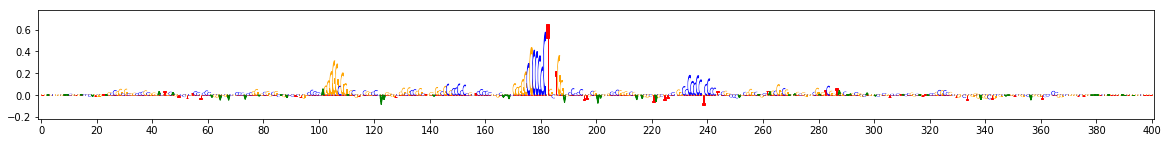

dlrescale_dinucshuffref10


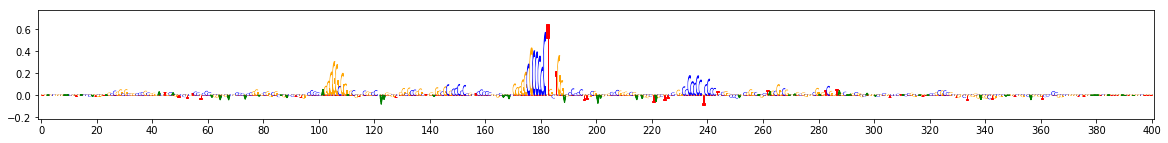

dlrescale_gcref


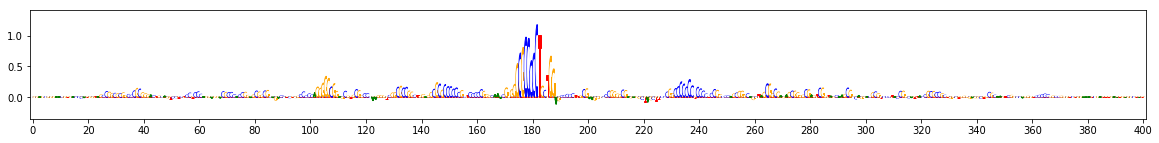

dlrescale_zeroref


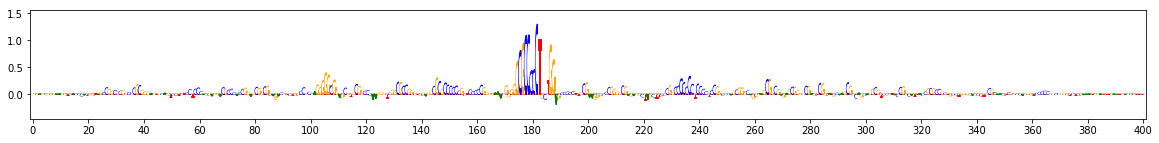

gradtimesinp


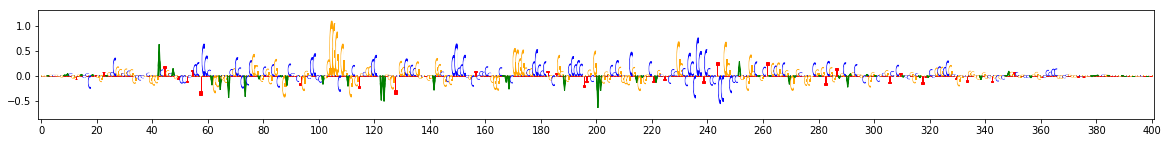

intgrad10_dinucshuffref10


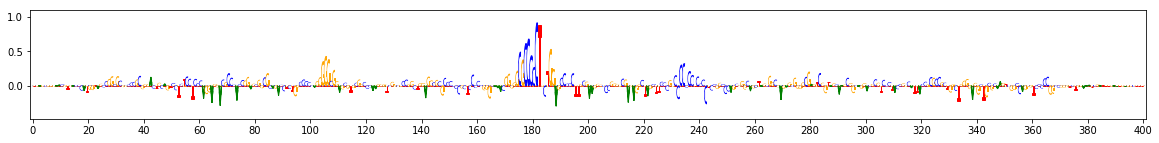

intgrad10_gcref


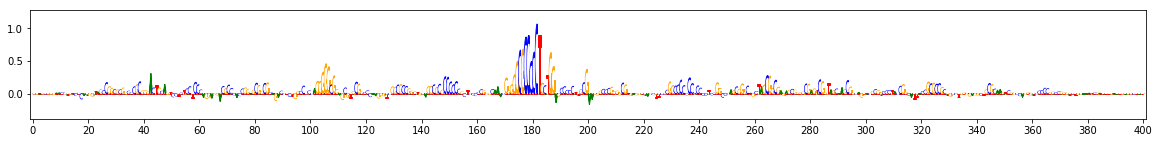

intgrad10_zeroref


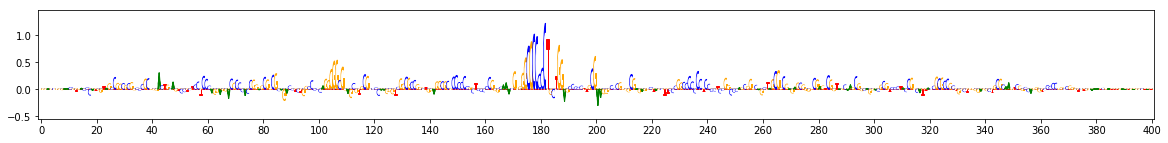

intgrad20_dinucshuffref10


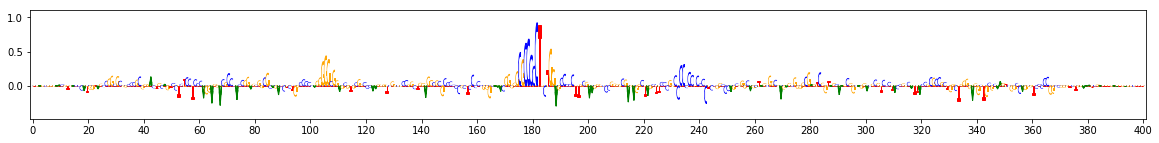

intgrad20_gcref


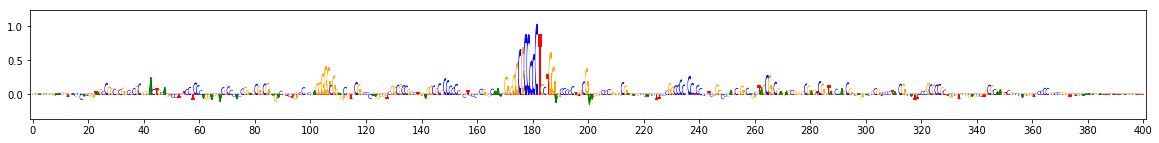

intgrad20_zeroref


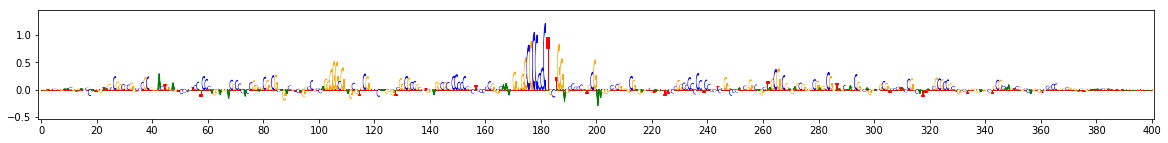

ism


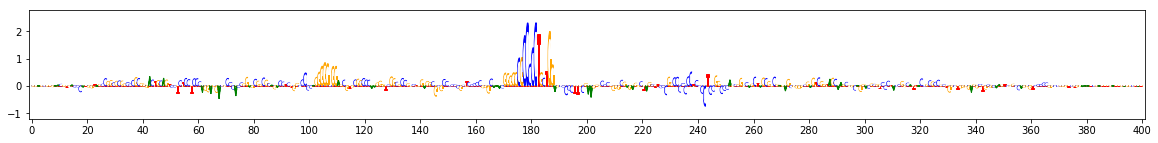

In [122]:
from deeplift.visualization import viz_sequence
for methodname in methodname_to_scores:
    print(methodname)
    scores = methodname_to_scores[methodname]
    viz_sequence.plot_weights(scores[0], subticks_frequency=20)

(33, ('dinuc_shuffled_motifs_implanted_chr15:64046382-64046782', 18.611666))
